# LeNet-300-100: Early Stopping

PyTorch code to show manual _early stopping_ implementation using MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [2]:
# GPU device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Available device: {device}")

Available device: cpu


In [3]:
# Hyper-parameters-
input_size = 784    # 28 x 28, flattened to be 1-D tensor
hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 32
learning_rate = 0.0012

In [4]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [5]:
os.chdir("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/")

In [6]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        transform = transforms_apply
        )

In [7]:
print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [8]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [9]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader), len(test_loader)

len(train_loader) = 1875 & len(test_loader) = 313


(1875, 313)

In [10]:
images, labels = next(iter(train_loader))

images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
# Sanity check- one batch of data
examples = iter(train_loader)

In [12]:
# Unpack-
img_samples, labels = examples.next()
print(f"img_samples.shape = {img_samples.shape}, labels.shape = {labels.shape}")
# img_samples.shape = torch.Size([32, 1, 28, 28]), labels.shape = torch.Size([32])
# We have '1' due to grey-scale images.

images[0][0].shape      # the second index '0' accesses the 1st channel

img_samples.shape = torch.Size([32, 1, 28, 28]), labels.shape = torch.Size([32])


torch.Size([28, 28])

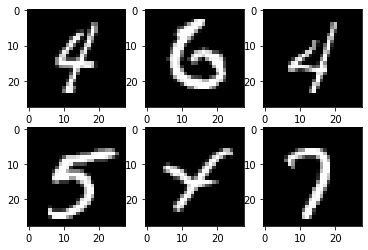

In [13]:
for i in range(6):
    plt.subplot(2, 3, i + 1)    # 2 rows & 3 columns
    plt.imshow(images[i][0], cmap = 'gray')     # '0' to access first channel
    # plt.imshow(img_samples[i][0], cmap='gray')  # '0' to access first channel
    
plt.show()

In [14]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = input_size, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.output = nn.Linear(in_features = 100, out_features = 10)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return self.output(out)
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [15]:
# Initialize an instance of LeNet-300-100 dense neural network-
model = LeNet300()

In [16]:
images.shape
# torch.Size([32, 1, 28, 28])

# images = images.reshape(-1, 28 * 28 * 1).to(device)
images.reshape(-1, 28 * 28 * 1).shape

torch.Size([32, 784])

In [17]:
# Sanity check- make predictions using define model-
model(images.reshape(-1, 28 * 28 * 1)).shape

torch.Size([32, 10])

In [18]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([300, 784]) has 235200 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([100, 300]) has 30000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([10, 100]) has 1000 parameters
layer.shape = torch.Size([10]) has 10 parameters


In [19]:
print(f"\nLeNet-300-100 has {tot_params} parameters\n")


LeNet-300-100 has 266610 parameters



In [20]:
print("\nLeNet-300-100 model's layer names are:")
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")


LeNet-300-100 model's layer names are:
fc1.weight has dimension = torch.Size([300, 784])
fc1.bias has dimension = torch.Size([300])
fc2.weight has dimension = torch.Size([100, 300])
fc2.bias has dimension = torch.Size([100])
output.weight has dimension = torch.Size([10, 100])
output.bias has dimension = torch.Size([10])


### Training Loop:

In [21]:
# Training loop-
num_steps = len(train_loader)

print(f"num_steps = {num_steps} & len(train_dataset)/batch_size = {len(train_dataset) / batch_size}")
print(f"number of training steps in one epoch = {num_steps}")

num_steps = 1875 & len(train_dataset)/batch_size = 1875.0
number of training steps in one epoch = 1875


In [22]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 5

In [24]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

# running_loss = 0.0
# running_corrects = 0

In [25]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [26]:
# Training loop-
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    running_loss_val = 0.0
    
    if loc_patience >= patience:
        print("\n\nEarly stopping called. Exiting model training!\n\n")
        break
    
    for batch, (images, labels) in enumerate(train_loader):
        # Reshape images first-
        # 32, 1, 28, 28
        # Input size needs to be 32, 784
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        # Tries to push to GPU if available
        
        labels = labels.to(device)
        
        # Set defined model to training mode-
        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        # Perform backpropagation-
        J.backward()

        # Update parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_steps}, loss = {J.item():.4f}")
        '''
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")
    
    
    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            # images = images.to(device)
            images = images.reshape(-1, 28 * 28 * 1).to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    # Code for manual Early Stopping:
    # if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
    if (epoch_val_loss < best_val_loss) and np.abs(epoch_val_loss - best_val_loss) >= minimum_delta:
        # print(f"epoch_val_loss = {epoch_val_loss:.4f}, best_val_loss = {best_val_loss:.4f}")
        
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"\nSaving model with lowest val_loss = {epoch_val_loss:.4f}")
        
        # Save trained model with validation accuracy-
        # torch.save(model.state_dict, f"LeNet-300-100_Trained_{val_acc}.pth")
        torch.save(model.state_dict, "LeNet-300-100_Trained.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

 



epoch: 1 training loss = 0.1977, training accuracy = 93.93%, val_loss = 0.1185 & val_accuracy = 96.58%


Saving model with lowest val_loss = 0.1185

epoch: 2 training loss = 0.0956, training accuracy = 97.03%, val_loss = 0.0948 & val_accuracy = 97.17%


Saving model with lowest val_loss = 0.0948

epoch: 3 training loss = 0.0715, training accuracy = 97.78%, val_loss = 0.0880 & val_accuracy = 97.45%


Saving model with lowest val_loss = 0.0880

epoch: 4 training loss = 0.0580, training accuracy = 98.23%, val_loss = 0.1016 & val_accuracy = 97.35%


epoch: 5 training loss = 0.0505, training accuracy = 98.39%, val_loss = 0.0946 & val_accuracy = 97.56%


epoch: 6 training loss = 0.0419, training accuracy = 98.66%, val_loss = 0.1079 & val_accuracy = 97.09%


epoch: 7 training loss = 0.0380, training accuracy = 98.80%, val_loss = 0.0896 & val_accuracy = 97.93%


epoch: 8 training loss = 0.0356, training accuracy = 98.91%, val_loss = 0.1046 & val_accuracy = 97.44%



Early stopping called. Exi

In [33]:
# Print trained model's state_dict-
for layer in model.state_dict():
    print(f"layer: {layer} has shape: {model.state_dict()[layer].shape}")

layer: fc1.weight has shape: torch.Size([300, 784])
layer: fc1.bias has shape: torch.Size([300])
layer: fc2.weight has shape: torch.Size([100, 300])
layer: fc2.bias has shape: torch.Size([100])
layer: output.weight has shape: torch.Size([10, 100])
layer: output.bias has shape: torch.Size([10])


In [36]:
# Save final trained model-
# torch.save(model.state_dict(), 'trained_model.pth')

In [37]:
trained_model = LeNet300()
# model = LeNet300()

In [38]:
trained_model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [39]:
# Set the model to evaluation mode-
trained_model.eval()

LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
)

In [41]:
# Get validation accuracy using trained and loaded model-
with torch.no_grad():
    num_correct = 0
    num_samples = 0

    for images, labels in test_loader:
        # Reshape images-
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        labels = labels.to(device)

        outputs = trained_model(images)

        # torch.max() returns value and index. We are interested in index
        # hence we use '_' since we don't need first value-
        _, y_pred = torch.max(outputs, 1)   # along first dimension
        
        # Compute validation loss-
        J_val = loss(outputs, labels)

        running_loss_val += J_val.item() * labels.size(0)


        # number of samples in correct batch-
        num_samples += labels.shape[0]

        num_correct += (y_pred == labels).sum().item()



In [42]:
val_acc = 100.0 * num_correct / num_samples
val_loss = running_loss_val / num_samples   # len(test_dataset)
print(f"\nTrained model's val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%\n")


Trained model's val_loss = 0.2092 & val_acc = 97.44%



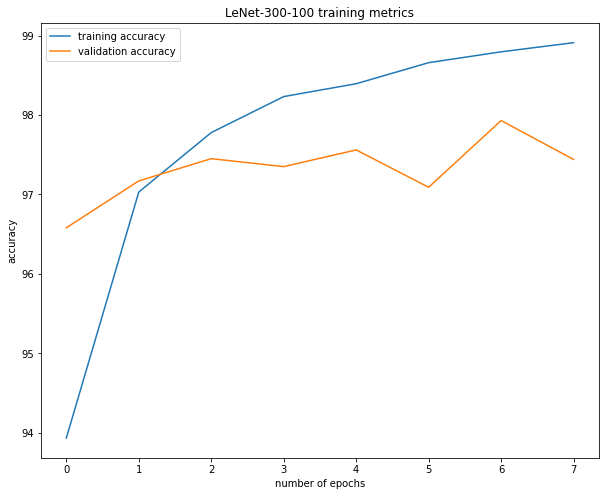

In [43]:
plt.figure(figsize = (10, 8))

plt.plot(training_acc, label = 'training accuracy')
plt.plot(validation_acc, label = 'validation accuracy')

plt.title("LeNet-300-100 training metrics")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.show()

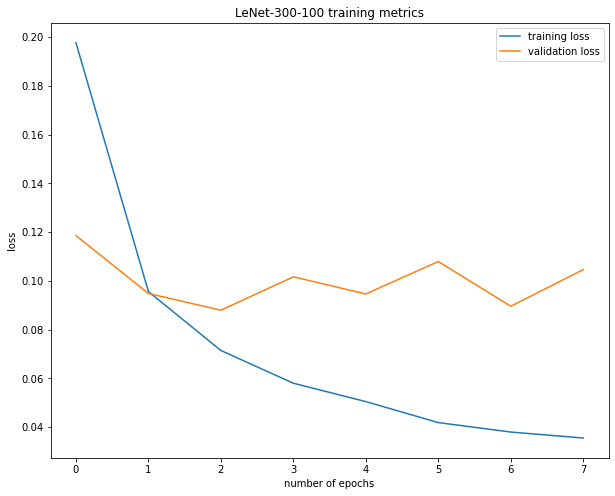

In [44]:
plt.figure(figsize = (10, 8))

plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')

plt.title("LeNet-300-100 training metrics")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()